In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve

import joblib
import os

In [ ]:
df = pd.read_csv("D:/Heart_Disease_Project/data/heart_disease_reduced.csv")
X = df.drop('num', axis=1)
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape : {X_test.shape}")

Training data shape: (242, 10)
Testing data shape : (61, 10)


In [23]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    },
    'Decision Tree': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}

In [24]:
best_models = {}
tuning_results = {}

for name in models:
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    tuning_results[name] = grid_search.cv_results_
    
    print(f"Best params for {name}: {grid_search.best_params_}")
    print(f"Best CV ROC AUC: {grid_search.best_score_:.4f}\n")

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best CV ROC AUC: 0.8962

Tuning Decision Tree...
Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best params for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best CV ROC AUC: 0.8209

Tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV ROC AUC: 0.8889

Tuning SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV ROC AUC: 0.8934



--- Logistic Regression (Tuned) ---
Accuracy : 0.902
Precision: 0.867
Recall   : 0.929
F1-Score : 0.897
AUC Score: 0.971

Confusion Matrix:
[[29  4]
 [ 2 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

--- Decision Tree (Tuned) ---
Accuracy : 0.770
Precision: 0.706
Recall   : 0.857
F1-Score : 0.774
AUC Score: 0.849

Confusion Matrix:
[[23 10]
 [ 4 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        33
           1       0.71      0.86      0.77        28

    accuracy                           0.77        61
   macro avg       0.78      0.78      0.77        61
weighted avg       0.78      0.77      0.

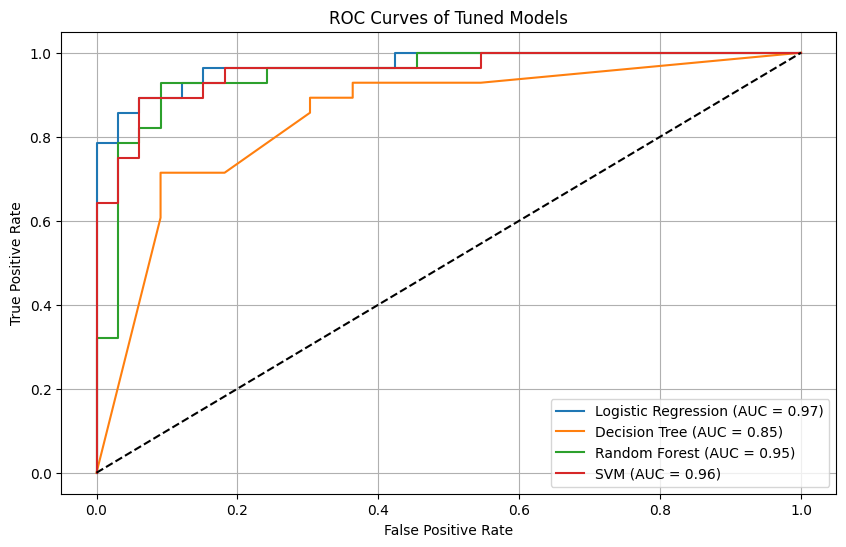

In [25]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"--- {name} (Tuned) ---")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    if auc is not None:
        print(f"AUC Score: {auc:.3f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.figure(figsize=(10, 6))
for name, model in best_models.items():
    evaluate_model(name, model, X_test, y_test)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Tuned Models')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
os.makedirs('models', exist_ok=True)

for name, model in best_models.items():
    filename = f"models/{name.lower().replace(' ', '_')}_tuned.pkl"
    joblib.dump(model, filename)

print("All tuned models saved successfully.")

All tuned models saved successfully.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', best_models['Random Forest'])
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, 'D:/Heart_Disease_Project/models/final.pkl')

print("Pipeline (preprocessing + model) saved as 'models/final.pkl'.")

Pipeline (preprocessing + model) saved as 'models/final.pkl'.
